In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow import keras
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
def get_dataset(dataset_dir):
    """Hàm này lấy dataset từ đường dẫn tệp dataset và lưu dataset dưới dạng Dataframe"""
    filepaths = list(dataset_dir.glob(r'**/*.jpg'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    dataset_df = pd.concat([filepaths, labels], axis=1)
    
    dataset_df = dataset_df.sample(frac=1).reset_index(drop = True)
    
    return dataset_df

dataset_dir = Path('D:/PC/Documents/Tensorflow/Rice Leaf Disease Diagnosis CNN Model/Rice Leaf Disease Dataset')
data_df = get_dataset(dataset_dir)

train_df, test_df = train_test_split(data_df, test_size = 0.9, random_state = 55, stratify=data_df["Label"])

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

Train size: 593
Test size: 5339


In [10]:
image_generator = ImageDataGenerator(rescale = 1.0/255.0)
test_images = image_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    seed = 5638,
    shuffle=False
)
CLASSES = list(test_images.class_indices.keys())

Found 5339 validated image filenames belonging to 4 classes.


In [5]:
def load_img_array(img_path):
    """Hàm này load ảnh và resize về kích thước phù hợp với mô hình"""
    img_size = (128, 128)
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

def predict_single_image(model, img_path):
    """
    Hàm này dự đoán nhãn của mẫu img trên model truyền vào
    In ra xác suất dự đoán trên các nhãn và nhãn có xác suất cao nhất
    """
    img_array = load_img_array(img_path)
    
    predictions = model.predict(img_array)
    probabilities = predictions[0]

    class_labels = ['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']

    for label, prob in zip(class_labels, probabilities):
        print(f"{label}: {prob:.2%}")

    predicted_label = class_labels[np.argmax(probabilities)]
    print(f"\nPredicted Label: {predicted_label}")

In [7]:
model = tf.keras.models.load_model('./Rice_leaf_disease_diagnosis (100%).h5')

In [11]:
test_scores = model.evaluate(test_images)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
pred_labels = model.predict(test_images)

def roundoff(arr):
    """Hàm này chuyển giá trị lớn nhất trong mảng truyền vào = 1, các giá trị còn lại = 0"""
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

pred = np.argmax(pred_labels,axis=1)

print(classification_report(test_images.classes,pred,target_names=CLASSES))

C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 7.7644e-04
Testing Accuracy: 99.98%
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step
                 precision    recall  f1-score   support

Bacterialblight       1.00      1.00      1.00      1426
          Blast       1.00      1.00      1.00      1296
      Brownspot       1.00      1.00      1.00      1440
         Tungro       1.00      1.00      1.00      1177

       accuracy                           1.00      5339
      macro avg       1.00      1.00      1.00      5339
   weighted avg       1.00      1.00      1.00      5339



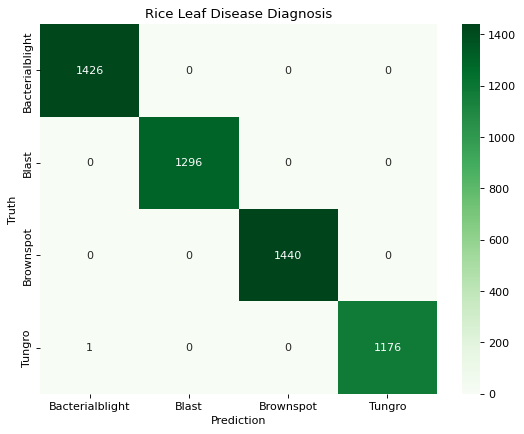

In [12]:
# Plot the confusion matrix to understand the classification in detail
test_ls, pred_ls = test_images.classes,pred
conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Rice Leaf Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
img_path = Path("C:/Users/PC/Downloads/image (3).jpg")
predict_single_image(model, img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Bacterialblight: 94.51%
Blast: 2.17%
Brownspot: 3.11%
Tungro: 0.21%

Predicted Label: Bacterialblight
